#  Development of an Order Volume Prediction System|

A taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak demand periods, it is necessary to forecast the number of taxi orders for the next hour.

**Workflow:**

1. Data loading and resampling to one-hour intervals.
2. Data analysis.
3. Training of various models with different hyperparameters.
4. Models evaluation on a test dataset.

The data is stored in the file `taxi.csv`, with the number of orders located in the `num_orders` column.


In [1]:
!pip install statsmodels -q


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.exceptions import FitFailedWarning
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Data preparation

In [3]:
taxi_df = pd.read_csv('../datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [4]:
taxi_df = taxi_df.resample('1H').sum()

In [5]:
display(taxi_df.head())
display(taxi_df.tail())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [6]:
taxi_df.isna().sum()

num_orders    0
dtype: int64

In [7]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Data analysis

In [8]:
rolling_mean = taxi_df['num_orders'].rolling(window=24).mean()

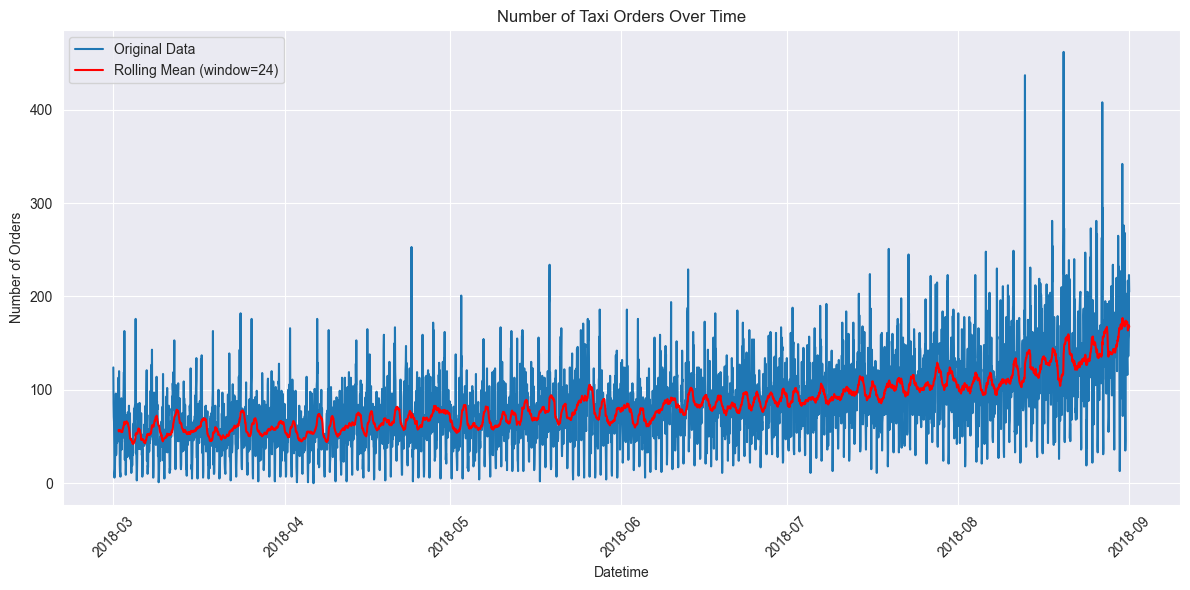

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='datetime', y='num_orders', data=taxi_df, label='Original Data')
plt.plot(taxi_df.index, rolling_mean, color='red', label='Rolling Mean (window=24)')

plt.xticks(rotation=45)

plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.title('Number of Taxi Orders Over Time')
plt.legend()
plt.tight_layout()
plt.show()

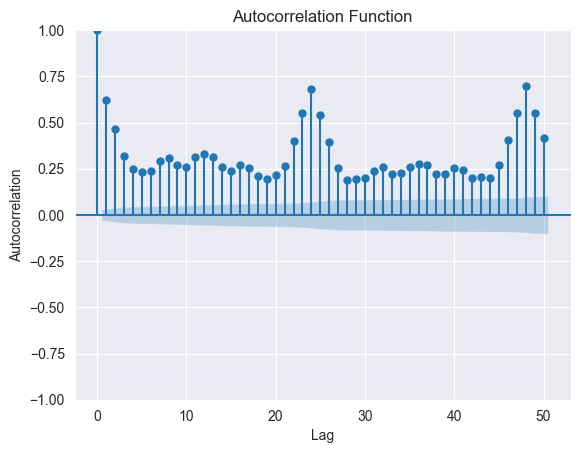

In [10]:
plot_acf(taxi_df['num_orders'], lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.show()

Lags 1, 2, and 24 show relatively high importance, so we add them as new features.

### Dickey-Fuller test

H<sub>0</sub> - non-stationary series
Н<sub>а</sub> - stationary series

In [11]:
a1 = 0.01
a5 = 0.05

result = adfuller(taxi_df['num_orders'])
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f' {key}: {value}')

Test Statistic: -3.0689242890279256
p-value: 0.028940051402615317
Critical Values:
 1%: -3.431842162413052
 5%: -2.8621993540813637
 10%: -2.567120978470452


In [12]:
if result[1] < a1:
    print('significance level 1%: do not reject the null hypothesis, the series is non-stationary')
else:
    print('significance level 1%: reject the null hypothesis - the series is stationary')
if result[1] < a5:\
    print('significance level 5%: we do not reject the null hypothesis, the series is non-stationary')
else:
    print('significance level 5%: reject the null hypothesis - the series is stationary')

significance level 1%: reject the null hypothesis - the series is stationary
significance level 5%: we do not reject the null hypothesis, the series is non-stationary


The moving average plot shows that the mean of the series is increasing. This suggests that the series is non-stationary. Additionally, we confirmed the non-stationarity of the series using the Dickey-Fuller test.

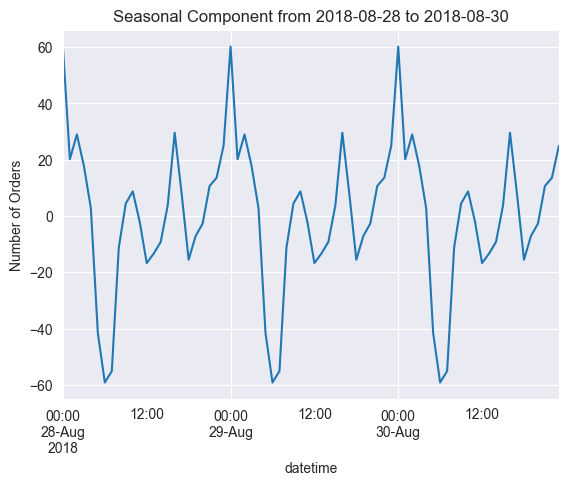

In [13]:
decomposed = seasonal_decompose(taxi_df)
plt.title('Seasonal Component from 2018-08-28 to 2018-08-30')
decomposed.seasonal['2018-08-28':'2018-08-30'].plot(ax=plt.gca())
plt.ylabel('Number of Orders')
plt.show()

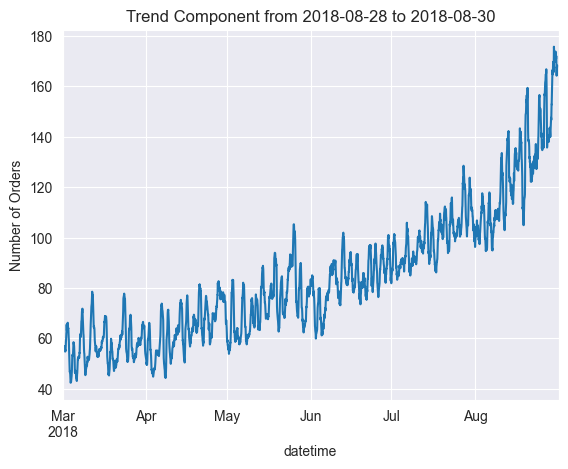

In [14]:
plt.title('Trend Component from 2018-08-28 to 2018-08-30')
decomposed.trend.plot(ax=plt.gca())
plt.ylabel('Number of Orders')
plt.show()

Based on the seasonal component, a daily cycle is observed. The highest values occur around midnight, likely due to the limited availability of public transportation at that time.
The trend shows an increase in the number of taxi orders. The data spans from March to August, and the growth may be related to the fact that people tend to travel more during the summer.

In [15]:
def make_features(df, rolling_mean_size):
    data = df.copy()
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in [1, 2, 24]:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [16]:
new_df = make_features(taxi_df, 12)
new_df = new_df.dropna()
new_df.head()

,num_orders,day,hour,dayofweek,lag_1,lag_2,lag_24,rolling_mean
datetime,,,,,,,,
2018-03-02 00:00:00,90,2,0,4,58.0,113.0,124.0,56.583333
2018-03-02 01:00:00,120,2,1,4,90.0,58.0,85.0,61.583333
2018-03-02 02:00:00,75,2,2,4,120.0,90.0,71.0,68.916667
2018-03-02 03:00:00,64,2,3,4,75.0,120.0,66.0,71.166667
2018-03-02 04:00:00,20,2,4,4,64.0,75.0,43.0,71.000000


The moving average was calculated using a 12-hour aggregation window.

## Model training

In [17]:
y = new_df['num_orders']
X = new_df.drop(['num_orders'], axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=TEST_SIZE)

All features are treated as numerical.

In [20]:
columns = ['day', 'hour', 'dayofweek', \
           'lag_1', 'lag_2', 'lag_24', 'rolling_mean']

In [21]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), columns)
    ], 
    remainder='passthrough'
)

In [22]:
final_p = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [23]:
parameters = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    ,
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],
        'models__max_depth': [3, 5, 7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [24]:
tscv = TimeSeriesSplit(n_splits=5)

In [25]:
search = GridSearchCV(
    final_p, 
    parameters,
    n_jobs=-1,
    cv=tscv, 
    scoring='neg_root_mean_squared_error',
    error_score='raise'
)

In [26]:
search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['day',
                                                                          'hour',
                                                                          'dayofweek',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_24',
                                                                          'rolling_mean'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [RandomForestRegressor(random_state=42)],
                          'models__max_depth': [3, 5, 7],
                          'models__n_estimators': [50, 100],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [27]:
results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,param_models__max_depth,param_models__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,0.346720,0.134083,0.006917,0.000471,RandomForestRegressor(random_state=42),StandardScaler(),7.0,100.0,{'models': RandomForestRegressor(random_state=...,-22.891082,-22.805561,-24.552191,-25.618843,-33.713603,-25.916256,4.039204,1
20,0.309288,0.108835,0.006318,0.000380,RandomForestRegressor(random_state=42),passthrough,7.0,100.0,{'models': RandomForestRegressor(random_state=...,-22.884783,-22.826253,-24.556685,-25.614061,-33.705837,-25.917524,4.033739,2
19,0.332804,0.118617,0.007105,0.000584,RandomForestRegressor(random_state=42),MinMaxScaler(),7.0,100.0,{'models': RandomForestRegressor(random_state=...,-22.886428,-22.813871,-24.570585,-25.614541,-33.704885,-25.918062,4.034086,3
16,0.169491,0.065892,0.004351,0.000310,RandomForestRegressor(random_state=42),MinMaxScaler(),7.0,50.0,{'models': RandomForestRegressor(random_state=...,-22.976970,-22.851080,-24.441125,-25.687968,-33.635281,-25.918485,3.996152,4
17,0.179974,0.069947,0.006281,0.002001,RandomForestRegressor(random_state=42),passthrough,7.0,50.0,{'models': RandomForestRegressor(random_state=...,-22.966716,-22.883417,-24.423862,-25.680412,-33.642797,-25.919441,3.997002,5


In [28]:
print(search.best_params_, (-1)*search.best_score_)

{'models': RandomForestRegressor(random_state=42), 'models__max_depth': 7, 'models__n_estimators': 100, 'preprocessor__num': StandardScaler()} 25.916255934100008


## Testing

In [29]:
best_model = search.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['day', 'hour', 'dayofweek',
                                                   'lag_1', 'lag_2', 'lag_24',
                                                   'rolling_mean'])])),
                ('models',
                 RandomForestRegressor(max_depth=7, random_state=42))])

In [30]:
y_pred = best_model.predict(X_test)

In [31]:
y_test

datetime
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
2018-08-13 19:00:00     91
2018-08-13 20:00:00     82
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: h, Name: num_orders, Length: 440, dtype: int64

In [32]:
y_train

datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
                      ... 
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
Freq: h, Name: num_orders, Length: 3952, dtype: int64

In [33]:
y_pred

array([122.45052602, 114.36085363, 112.48813131, 106.36973214,
       103.72019691, 109.20718353, 132.42245505, 130.29449187,
       181.56459128, 159.39357311, 158.10991515, 146.97876951,
       127.255662  ,  95.59943601,  43.40473658,  38.20157277,
        78.07555726, 109.28760175, 119.28711918, 121.79539543,
       113.04597968, 110.85425362,  89.46826931, 115.29860215,
       118.69422632, 117.81257507, 112.60641626, 100.4583198 ,
       106.63388336, 111.12128919, 121.34406048, 116.27659123,
       169.80371732, 165.51086499, 159.16032593, 125.60941326,
       132.80778133,  63.19525184,  55.06756096,  38.85907659,
        80.47781342, 106.23889514, 116.29998984, 117.94312663,
       108.0843774 ,  87.34955204,  98.49337658, 104.69764848,
       104.37529063, 122.25408511, 112.61745155, 106.91950983,
       109.19588378, 120.06235559, 127.17624382, 138.61127513,
       187.36538694, 150.06762421, 164.59663999, 143.50328478,
       141.04975684,  99.24686925,  52.15240115,  34.95

In [34]:
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE Test: {rmse_test:.4f}')

RMSE Test: 47.4546


In [35]:
y_pred_train = best_model.predict(X_train)

# 2. Calculate RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f'RMSE Train: {rmse_train:.4f}')

RMSE Train: 20.4897


The predicted values differ significantly from the actual ones, primarily because the distributions of the `train` and `test` sets differ — the test set exhibits higher fluctuations that the model was not prepared for.
Despite this, the evaluation metric on the test set remains below 48, which is acceptable. As a result, the optimal configuration was found to be a maximum tree depth of 5 and up to 100 trees.

In [36]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)
mse_dummy_test = mean_squared_error(y_test, y_pred_dummy)
rmse_dummy_test = np.sqrt(mse_dummy_test)

print(f'RMSE test, DummyRegressor: {rmse_dummy_test:.4f}')

RMSE test, DummyRegressor: 84.6877


The best-performing model is:

**`RandomForestRegressor(max_depth=7, n_estimators=50, random_state=42)`**
with pipeline parameters:

* `'models__max_depth': 7`
* `'models__n_estimators': 50`
* `'preprocessor__num': 'passthrough'` (i.e., no transformation on numeric features)

**Evaluation results:**

* RMSE on the training set: **20.5**
* RMSE on the test set: **47.5**

This model significantly outperforms the `DummyRegressor` baseline in terms of the RMSE metric.

## Results visualization

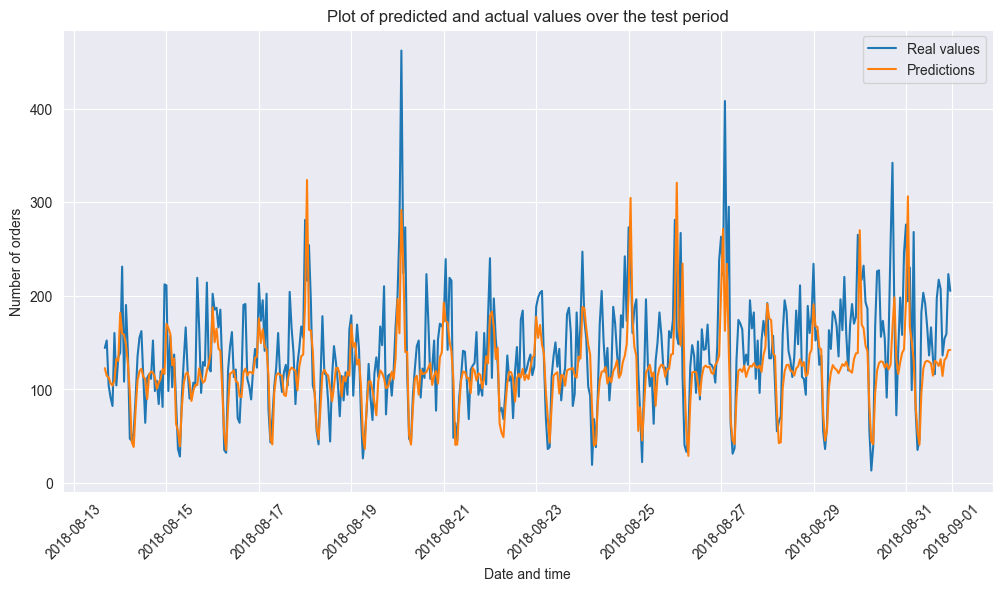

In [37]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=new_df.iloc[len(y_train):], x=new_df.index[len(y_train):], y='num_orders', label='Real values')
sns.lineplot(data=new_df.iloc[len(y_train):], x=new_df.index[len(y_train):], y=y_pred, label='Predictions')

plt.title('Plot of predicted and actual values over the test period')
plt.xlabel('Date and time')
plt.ylabel('Number of orders')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()